In [23]:
from tensorflow.keras.models import load_model

import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import joblib

sys.path.append(os.path.join(os.path.dirname('__file__'), "./../"))
from stepcovnet.wrapper.timing_prediction import smooth_obs, boundary_decoding
from stepcovnet.common.utils import feature_reshape
from stepcovnet.common.audio_preprocessing import get_madmom_log_mels
from madmom.features.onsets import OnsetPeakPickingProcessor

In [4]:
model = load_model(os.path.join('models', 'trained_model.h5'), custom_objects=custom_objects, compile=False)

In [11]:
model = load_model(os.path.join('models', 'retrained_model.h5'), custom_objects=custom_objects, compile=False)

In [4]:
model.summary()

Model: "StepNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 15, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 9, 16)         1024      
_________________________________________________________________
batch_normalization (BatchNo (None, 78, 9, 16)         64        
_________________________________________________________________
activation (Activation)      (None, 78, 9, 16)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 9, 16)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 26, 9, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 7, 32)         4640

In [63]:
from sklearn.externals import joblib
pca = joblib.load('7comp_pca.pkl')

In [1]:
from sklearn.externals import joblib
pca = joblib.load('11comp_pca.pkl')

c:\users\mrchr\miniconda3\envs\tf2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [47]:
from sklearn.externals import joblib
pca = joblib.load('117comp_pca.pkl')

In [8]:
from sklearn.externals import joblib
pca = joblib.load('19_multi_comp_pca.pkl')

In [6]:
import xgboost as xgb
bst = xgb.Booster({'nthread':-1})
bst.load_model('colab_xgb_model.model')
multi = False
scaler = []
with open("training_data/under_scaler.pkl", "rb") as file:
    scaler.append(joblib.load(file))

In [ ]:
log_mel_pca = pca.transform(log_mel)

In [5]:
import xgboost as xgb
bst = xgb.Booster({'nthread':-1})
bst.load_model('colab_multi_xgb_model.model')
multi = True
scaler = []
with open("training_data/multi_under_scaler_low.pkl", "rb") as file:
    scaler.append(joblib.load(file))
with open("training_data/multi_under_scaler_mid.pkl", "rb") as file:
    scaler.append(joblib.load(file))
with open("training_data/multi_under_scaler_high.pkl", "rb") as file:
    scaler.append(joblib.load(file))

In [9]:
log_mel_pca = pca.transform(log_mel.reshape(log_mel.shape[0], log_mel.shape[1]*log_mel.shape[2]))

In [10]:
dmel = xgb.DMatrix(log_mel_pca)
pdf_xgb = bst.predict(dmel)
pdf_xgb = np.squeeze(pdf_xgb)
pdf_xgb = smooth_obs(pdf_xgb)

In [4]:
import lightgbm as lgb
lgb = lgb.Booster(model_file='colab_multi_lgb_model.model')
multi = True
scaler = []
with open("training_data/multi_under_scaler_low.pkl", "rb") as file:
    scaler.append(joblib.load(file))
with open("training_data/multi_under_scaler_mid.pkl", "rb") as file:
    scaler.append(joblib.load(file))
with open("training_data/multi_under_scaler_high.pkl", "rb") as file:
    scaler.append(joblib.load(file))

In [9]:
pdf = lgb.predict(log_mel_pca)
pdf = np.squeeze(pdf)
pdf = smooth_obs(pdf)

In [5]:
scaler = []

if model.layers[0].input_shape[0][1] != 1:
    multi = True
else:
    multi = False

if multi:
    with open("training_data/multi_scaler_low.pkl", "rb") as file:
        scaler.append(joblib.load(file))
    with open("training_data/multi_scaler_mid.pkl", "rb") as file:
        scaler.append(joblib.load(file))
    with open("training_data/multi_scaler_high.pkl", "rb") as file:
        scaler.append(joblib.load(file))
else:
    with open("training_data/scaler.pkl", "rb") as file:
        scaler.append(joblib.load(file))


In [24]:
wav = 'testing_files/zombie_maker.wav'

if multi:
    log_mel = get_madmom_log_mels(wav, 44100, 0.01, channel=3)

    log_mel[:, :, 0] = scaler[0].transform(log_mel[:, :, 0])
    log_mel[:, :, 1] = scaler[1].transform(log_mel[:, :, 1])
    log_mel[:, :, 2] = scaler[2].transform(log_mel[:, :, 2])
else:
    log_mel = get_madmom_log_mels(wav, 44100, 0.01, channel=1)
    log_mel = scaler[0].transform(log_mel)

In [14]:
with open("colab_multi_rf_model.model", "rb") as file:
    rf = joblib.load(file)

In [17]:
pdf = rf.predict(log_mel_pca)
pdf = np.squeeze(pdf)
pdf = smooth_obs(pdf)

In [25]:
log_mel_re = feature_reshape(log_mel, multi, 7)
if not multi:
    log_mel_re = np.expand_dims(log_mel_re, axis=1)
pdf = model.predict(log_mel_re)
pdf = np.squeeze(pdf)
pdf = smooth_obs(pdf)

In [8]:
snip = pdf_xgb[50: 60*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylim(0, 1)
plt.show()

NameError: name 'pdf_xgb' is not defined

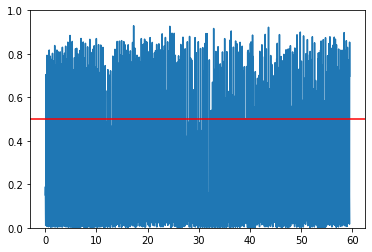

In [18]:
snip = pdf[50: 60*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylim(0, 1)
plt.show()

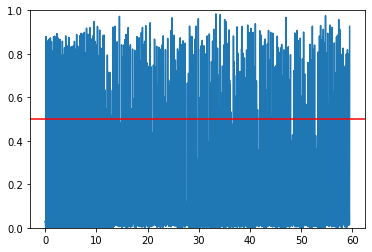

In [55]:
snip = pdf[50: 60*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylim(0, 1)
plt.show()

In [40]:
pdf_avg = 0.2*pdf_xgb + 0.8*pdf
b_baseline_avg = boundary_decoding(obs_i=pdf_avg,
                              threshold=0.5,
                              hopsize_t=0.01,
                              OnsetPeakPickingProcessor=OnsetPeakPickingProcessor)
lines = []
with open("training_data/timings/zi-zis_journey.txt", "r") as file:
    lines = file.readlines()
    lines = np.asarray([x.replace("\n", "").split(" ")[1] for x in lines[3:]]).astype("float")
    
lines.shape, b_baseline_xgb.shape

((587,), (605,))

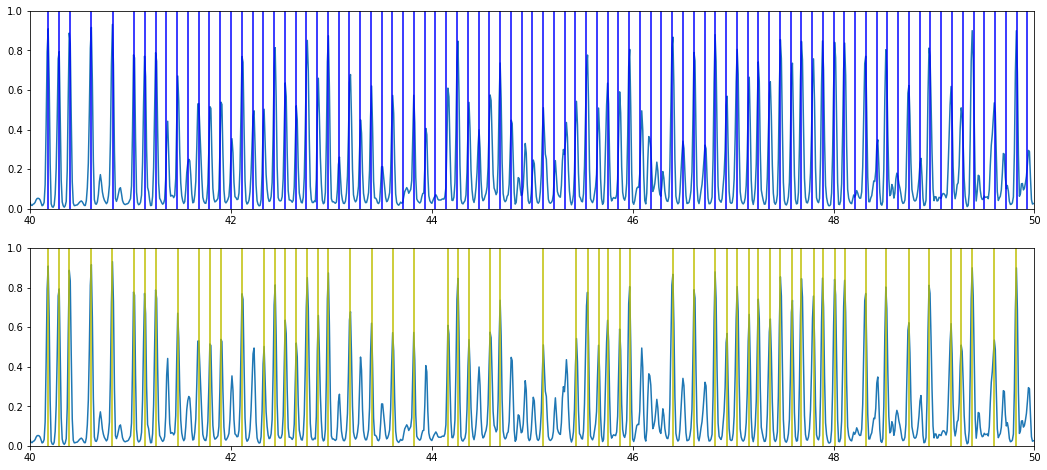

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(18, 8)
start = 40
end = 50
snip = pdf_avg[start * 100: end*100]
x = np.arange(start*100, end*100) * 0.01

ax1 = plt.subplot(211)
ax1.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in lines:
    if mark < start:
        continue
    elif mark > end:
        break
    ax1.axvline(x=mark, color= 'b')
plt.xlim(start, end)
plt.ylim(0, 1)

ax2 = plt.subplot(212)
ax2.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in b_baseline_avg*0.01:
    if mark < start:
        continue
    elif mark > end:
        break
    ax2.axvline(x=mark, color= 'y')
plt.xlim(start, end)
plt.ylim(0, 1)

plt.show()

In [16]:
b_baseline_xgb = boundary_decoding(obs_i=pdf_xgb,
                              threshold=0.5,
                              hopsize_t=0.01,
                              OnsetPeakPickingProcessor=OnsetPeakPickingProcessor)
lines = []
with open("training_data/timings/zombie_maker.txt", "r") as file:
    lines = file.readlines()
    lines = np.asarray([x.replace("\n", "").split(" ")[1] for x in lines[3:]]).astype("float")
    
lines.shape, b_baseline_xgb.shape

((587,), (605,))

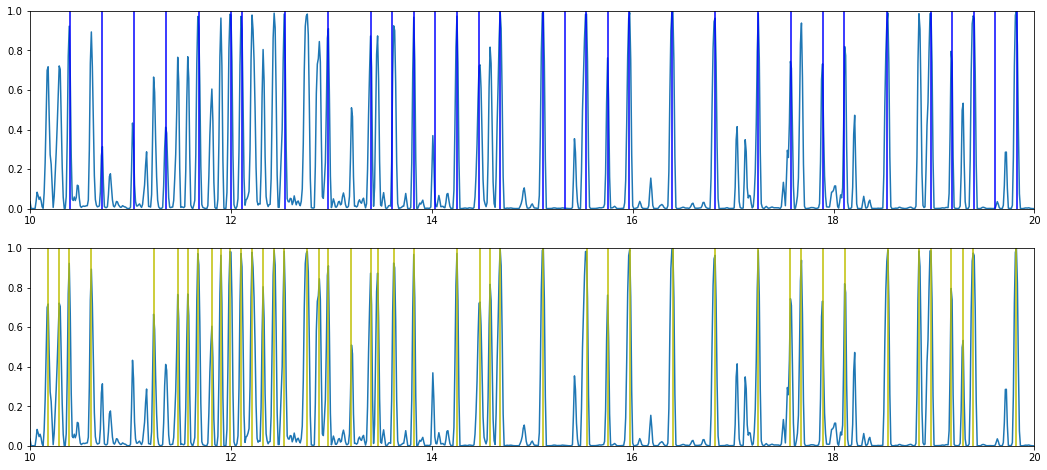

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(18, 8)
start = 10
end = 20
snip = pdf[start * 100: end*100]
x = np.arange(start*100, end*100) * 0.01

ax1 = plt.subplot(211)
ax1.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in lines:
    if mark < start:
        continue
    elif mark > end:
        break
    ax1.axvline(x=mark, color= 'b')
plt.xlim(start, end)
plt.ylim(0, 1)

ax2 = plt.subplot(212)
ax2.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in b_baseline*0.01:
    if mark < start:
        continue
    elif mark > end:
        break
    ax2.axvline(x=mark, color= 'y')
plt.xlim(start, end)
plt.ylim(0, 1)

plt.show()

In [10]:
b_baseline = boundary_decoding(obs_i=pdf,
                              threshold=0.5,
                              hopsize_t=0.01,
                              OnsetPeakPickingProcessor=OnsetPeakPickingProcessor)
lines = []
with open("training_data/timings/zombie_maker.txt", "r") as file:
    lines = file.readlines()
    lines = np.asarray([x.replace("\n", "").split(" ")[1] for x in lines[3:]]).astype("float")
    
lines.shape, b_baseline.shape

FileNotFoundError: [Errno 2] No such file or directory: 'training_data/timings/zi-zis_journey.txt'

In [19]:
b_baseline = boundary_decoding(obs_i=pdf,
                              threshold=0.5,
                              hopsize_t=0.01,
                              OnsetPeakPickingProcessor=OnsetPeakPickingProcessor)
lines = []
with open("testing_files/zombie_maker.txt", "r") as file:
    lines = file.readlines()
    lines = np.asarray([x.replace("\n", "").split(" ")[1] for x in lines[3:]]).astype("float")
    
lines.shape, b_baseline.shape

((668,), (634,))

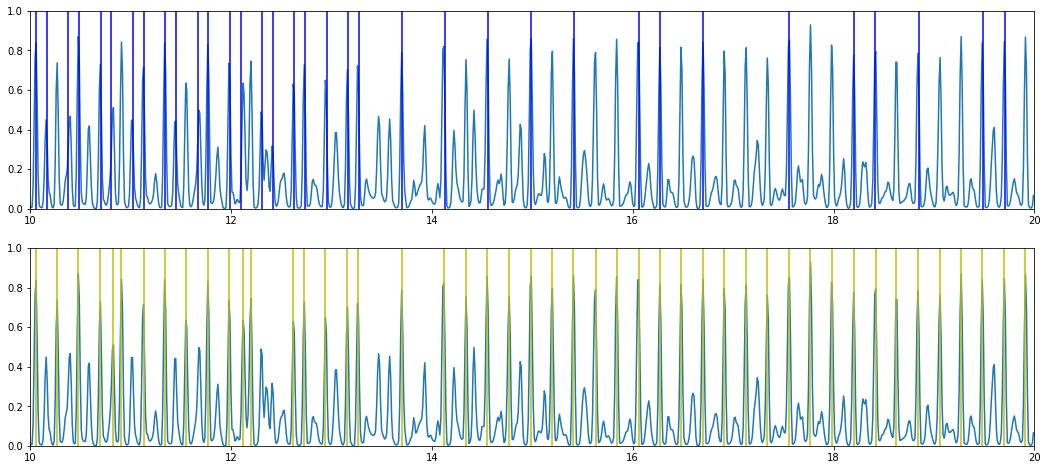

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(18, 8)
start = 10
end = 20
snip = pdf[start * 100: end*100]
x = np.arange(start*100, end*100) * 0.01

ax1 = plt.subplot(211)
ax1.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in lines:
    if mark < start:
        continue
    elif mark > end:
        break
    ax1.axvline(x=mark, color= 'b')
plt.xlim(start, end)
plt.ylim(0, 1)

ax2 = plt.subplot(212)
ax2.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in b_baseline*0.01:
    if mark < start:
        continue
    elif mark > end:
        break
    ax2.axvline(x=mark, color= 'y')
plt.xlim(start, end)
plt.ylim(0, 1)

plt.show()

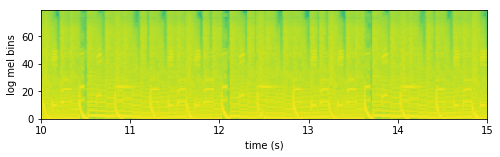

In [66]:
plt.figure(figsize=(8,2))
y = np.arange(0, 80)
x = np.arange(0, log_mel.shape[0]) * 0.01
plt.pcolormesh(x, y, np.transpose(log_mel_te[:, :, 7, 0]))
plt.ylabel('log mel bins')
plt.xlabel('time (s)')
plt.xlim(10, 15)
plt.show()

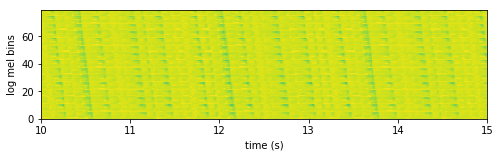

In [50]:
plt.figure(figsize=(8,2))
y = np.arange(0, 80)
x = np.arange(0, log_mel.shape[0]) * 0.01
plt.pcolormesh(x, y, np.transpose(log_mel_re[:, :, 7, 0]))
plt.ylabel('log mel bins')
plt.xlabel('time (s)')
plt.xlim(10, 15)
plt.show()

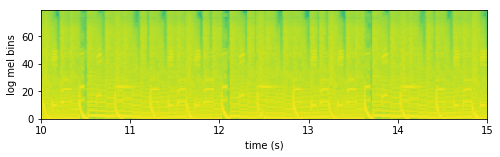

In [38]:
plt.figure(figsize=(8,2))
y = np.arange(0, 80)
x = np.arange(0, log_mel.shape[0]) * 0.01
plt.pcolormesh(x, y, np.transpose(log_mel[:, 80 * 7:80 * 8,0]))
plt.ylabel('log mel bins')
plt.xlabel('time (s)')
plt.xlim(10, 15)
plt.show()

In [72]:
source = np.random.rand(100000,100)

In [73]:
test1 = source #np.ones((100000, 100))
test1_sam = test1[:test1.shape[0]//2]
test1_sam.shape, test1.shape

((50000, 100), (100000, 100))

In [74]:
test2 = source #np.ones((100000, 100))
test2_sam = test2[::2]
test2_sam.shape, test2.shape

((50000, 100), (100000, 100))

In [76]:
test3 = source #np.ones((100000, 100))
indexes = np.asarray(range(len(test3)))
indexes_sam = np.random.choice(indexes, test3.shape[0]//2)
test3_sam = test3[indexes_sam]
test3_sam.shape, test3.shape

((50000, 100), (100000, 100))

In [77]:
test4 = source #np.ones((100000, 100))
#indexes = np.asarray(range(len(test4)))
#indexes_sam = np.sort(np.random.choice(indexes, test4.shape[0]//2))
test4_sam = test3[np.sort(indexes_sam)]
test4_sam.shape, test4.shape

((50000, 100), (100000, 100))

In [78]:
from os.path import join
np.savez_compressed(join('test1'), test1_sam)
np.savez_compressed(join('test2'), test2_sam)
np.savez_compressed(join('test3'), test3_sam)
np.savez_compressed(join('test4'), test4_sam)